In [44]:
from augur.utils import json_to_tree
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D  
import scipy.stats

### Plot mutations per gene versus logistic growth rate

Find the correlation coefficent between logisitic growth rate of a node and the number of mutations it has in a gene.
Do this for each time point throughout the pandemic, and plot the correlation over time

In [45]:
all_genes = ['Nsp1', 'Nsp2', 'Nsp3', 'Nsp4', 'Nsp5', 'Nsp6', 'Nsp7', 'Nsp8', 
             'Nsp9', 'Nsp10', 'Nsp12', 'Nsp13', 'Nsp14', 'Nsp15', 'Nsp16', 
             'S', 'S1', 'S2', 'ORF3a', 'E', 'M', 'ORF6', 'ORF7a', 
             'ORF7b', 'ORF8', 'N', 'ORF9b', 'ORF10']

In [46]:
def readin_tree(date, tree_type):
    """
    Read in the 2m tree json for the specified date
    """

    # path to tree json
    if tree_type == 'sars2':
        tree_file = f'trees_w_mut_counts/sars2_{date}_2m.json'
    elif tree_type == '21L':
        tree_file = f'trees_w_mut_counts/sars2_21L_{date}_2m.json'    

    with open(tree_file, 'r') as f:
        tree_json = json.load(f)

    # put tree in Bio.phylo format
    tree = json_to_tree(tree_json)
    
    return tree

In [47]:
def get_mut_and_growth_info(date, tree_type):
    """
    Get logistic growth and number of mutations for each node in the tree
    """
    tree = readin_tree(date, tree_type)
    
    mut_and_growth_info = []
    
    
    for node in tree.find_clades():
        # only for nodes that have an assigned logistic growht rate (those that are in the past 6 weeks)
        if 'logistic_growth' in node.node_attrs:
            logistic_growth = node.node_attrs['logistic_growth']['value']
            # look at mutations in each gene
            for gene in all_genes:
                nonsyn_muts = node.mut_accumulation['Nonsyn_muts'][gene]
                syn_muts = node.mut_accumulation['Syn_muts'][gene]
                stop_muts = node.mut_accumulation['Stop_muts'][gene]
                
                mut_and_growth_info.append({'date': date, 'gene':gene, 'node': node.name,
                                            'logistic_growth': logistic_growth, 
                                            'nonsyn': nonsyn_muts, 'syn': syn_muts, 'stop': stop_muts})
                
    df = pd.DataFrame(mut_and_growth_info)
    
    return df

In [48]:
def get_correlations(date, df):
    """
    Get correlation coefficient r for mutations in each gene vs logisitic growth rate
    Do this for each type of mutation
    """
    
    pearsons_r = []
    
    for gene in all_genes:
        df_gene = df[df['gene']==gene]
        x_n = df_gene['nonsyn'].to_numpy()
        x_s = df_gene['syn'].to_numpy()
        x_stop = df_gene['stop'].to_numpy()
        y = df_gene['logistic_growth'].to_numpy()
        # get the Pearson's r. scipy return (r, p-value)
        r_nonsyn = scipy.stats.pearsonr(x_n, y)[0]
        r_syn = scipy.stats.pearsonr(x_s, y)[0]
        # gets angry about having all 0's
#         r_stop = scipy.stats.pearsonr(x_stop, y)[0]
        pearsons_r.append({'date': date, 'gene': gene, 'r_nonsyn': r_nonsyn, 'r_syn': r_syn})

    pearsons_df = pd.DataFrame(pearsons_r)
    return pearsons_df

In [49]:
# run all dates, so they're saved in memory
all_dates = ['2020-03', '2020-05', '2020-07', '2020-09', '2020-11', 
             '2021-01', '2021-03', '2021-05', '2021-07', '2021-09', '2021-11', 
             '2022-01', '2022-03', '2022-05', '2022-07', '2022-09', '2022-11', 
             '2023-01', '2023-03', '2023-05']
pearsons_df_sars2 = pd.DataFrame()

for date in all_dates:
    df_date = get_mut_and_growth_info(date, 'sars2')

    pearsons_df_date = get_correlations(date, df_date)
    pearsons_df_sars2 = pd.concat([pearsons_df_sars2, pearsons_df_date])

/Users/katekistler/opt/miniconda3/envs/nextstrain/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [50]:
# run all dates for 21L,
all_dates_21L = ['2022-03', '2022-04', '2022-05', '2022-06', '2022-07', 
             '2022-08', '2022-09', '2022-10', '2022-11', 
             '2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06']
pearsons_df_21L = pd.DataFrame()

for date in all_dates_21L:
    df_date = get_mut_and_growth_info(date, '21L')

    pearsons_df_date = get_correlations(date, df_date)
    pearsons_df_21L = pd.concat([pearsons_df_21L, pearsons_df_date])

In [51]:
def correlations_over_time(pearsons_df, genes_to_plot = all_genes):
    """
    For each gene, plot the correlation between mutations and logsitic growth rate over all of the dates
    """


    #plot text styling
    sns.set_style("white")
    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 6
    
    plt.rcParams['figure.dpi']= 300
    
    #greens= structural proteins
    #darker green= surface, lighter= non-surface
    #reds = nonstructural proteins
    #oranges/yellows = accessory proteins
    legend_colors = {'Non-structural': '#9F2A44', 
                     'Structural,\nsurface': '#208288', 
                     'Structural,\nnon-surface': '#76C7BE', 
                     'Accessory':'#F5AD52'}
    legend_edgecolors = {'Non-structural': '#621a2a', 
                     'Structural,\nsurface': '#165b5f', 
                     'Structural,\nnon-surface': '#46ab97', 
                     'Accessory':'#eb520d'}
    
    # color map, where gene is colored by ~function
    type_cmap = {'Nsp1': '#9F2A44', 'Nsp2': '#9F2A44', 'Nsp3': '#9F2A44', 'Nsp4': '#9F2A44', 
           'Nsp5': '#9F2A44', 'Nsp6': '#9F2A44', 'Nsp7': '#9F2A44', 'Nsp8': '#9F2A44', 
           'Nsp9': '#9F2A44', 'Nsp10': '#9F2A44', 'Nsp12': '#9F2A44', 
           'Nsp13': '#9F2A44', 'Nsp14': '#9F2A44', 'Nsp15': '#9F2A44', 'Nsp16': '#9F2A44', 
           'S': '#208288', 'S1': '#208288', 'S2': '#208288', 'ORF3a': '#F5AD52', 
           'E': '#76C7BE', 'M': '#76C7BE', 'ORF6': '#F5AD52', 'ORF7a': '#F5AD52', 
           'ORF7b': '#F5AD52', 'ORF8': '#F5AD52', 'N': '#76C7BE', 'ORF9b': '#F5AD52', 'ORF10': '#F5AD52'}
    type_edge_cmap = {'Nsp1': '#621a2a', 'Nsp2': '#621a2a', 'Nsp3': '#621a2a', 'Nsp4': '#621a2a', 
                 'Nsp5': '#621a2a', 'Nsp6': '#621a2a', 'Nsp7': '#621a2a', 'Nsp8': '#621a2a', 
                 'Nsp9': '#621a2a', 'Nsp10': '#621a2a', 'Nsp12': '#621a2a', 'Nsp13': '#621a2a', 
                 'Nsp14': '#621a2a', 'Nsp15': '#621a2a', 'Nsp16': '#621a2a', 
                 'S': '#165b5f', 'S1': '#165b5f', 'S2': '#165b5f', 'ORF3a': '#eb520d', 
                 'E': '#46ab97', 'M': '#46ab97', 'ORF6': '#eb520d', 'ORF7a': '#eb520d', 
                 'ORF7b': '#eb520d', 'ORF8': '#eb520d', 'N': '#46ab97', 'ORF9b': '#eb520d', 'ORF10': '#eb520d'}
    
    # color map, where each gene has a different color
    gene_cmap = {'Nsp1': '#9F2A44', 'Nsp2': '#9F2A44', 'Nsp3': '#9F2A44', 'Nsp4': '#9F2A44', 
           'Nsp5': '#9F2A44', 'Nsp6': '#9F2A44', 'Nsp7': '#9F2A44', 'Nsp8': '#9F2A44', 
           'Nsp9': '#9F2A44', 'Nsp10': '#9F2A44', 'Nsp12': '#9F2A44', 
           'Nsp13': '#9F2A44', 'Nsp14': '#9F2A44', 'Nsp15': '#9F2A44', 'Nsp16': '#9F2A44', 
           'S': '#208288', 'S1': '#208288', 'S2': '#2aa9b1', 'ORF3a': '#F5AD52', 
           'E': '#76C7BE', 'M': '#9ad6cf', 'ORF6': '#F5AD52', 'ORF7a': '#F5AD52', 
           'ORF7b': '#F5AD52', 'ORF8': '#F5AD52', 'N': '#cae9e6', 'ORF9b': '#F5AD52', 'ORF10': '#F5AD52'}
    gene_edge_cmap = {'Nsp1': '#621a2a', 'Nsp2': '#621a2a', 'Nsp3': '#621a2a', 'Nsp4': '#621a2a', 
                 'Nsp5': '#621a2a', 'Nsp6': '#621a2a', 'Nsp7': '#621a2a', 'Nsp8': '#621a2a', 
                 'Nsp9': '#621a2a', 'Nsp10': '#621a2a', 'Nsp12': '#621a2a', 'Nsp13': '#621a2a', 
                 'Nsp14': '#621a2a', 'Nsp15': '#621a2a', 'Nsp16': '#621a2a', 
                 'S': '#165b5f', 'S1': '#165b5f', 'S2': '#1d7a7f', 'ORF3a': '#eb520d', 
                 'E': '#4cb6aa', 'M': '#62bfb4', 'ORF6': '#eb520d', 'ORF7a': '#eb520d', 
                 'ORF7b': '#eb520d', 'ORF8': '#eb520d', 'N': '#86cdbf', 'ORF9b': '#eb520d', 'ORF10': '#eb520d'}
    
    # initiate axis
    fig, ax = plt.subplots(figsize=(6,4))
    
    # add horizontal line at y=0
    ax.axhline(y=0.0, color='#646464', linestyle='--')
    for g in genes_to_plot:
        if genes_to_plot== all_genes:
            cmap = type_cmap
            edge_cmap = type_edge_cmap
        else:
            cmap = gene_cmap
            edge_cmap = gene_edge_cmap
        df_subset = pearsons_df[pearsons_df['gene']==g]
        X = df_subset['date']
        Y = df_subset['r_nonsyn']
        ax.plot(X, Y, 'o', ms=8, color=cmap[g], markeredgecolor=edge_cmap[g], zorder=2, label=g)
        ax.plot(X, Y, color=edge_cmap[g], zorder=1)
        

    
    #add a legend
    if genes_to_plot == all_genes:
        handles = []
        leg_text = []
        for k,v in legend_colors.items():
            handles.append(Line2D([], [], color='white', marker='o', 
                                  markerfacecolor=v, markeredgecolor=legend_edgecolors[k], markersize=8))
            leg_text.append(k)

        leg = ax.legend(handles, leg_text,
                          bbox_to_anchor=(1.0, 1.1), frameon=True, labelspacing = 1.0, borderpad=1)
    else:
        ax.legend(bbox_to_anchor=(1.0, 1.1), frameon=True, labelspacing = 1.0, borderpad=1)
        
    
    sns.despine()
    
    ax.set_xlabel('Date')
    ax.set_ylabel("Pearson's r")
    
    ax.xaxis.set_tick_params(rotation=90)
        

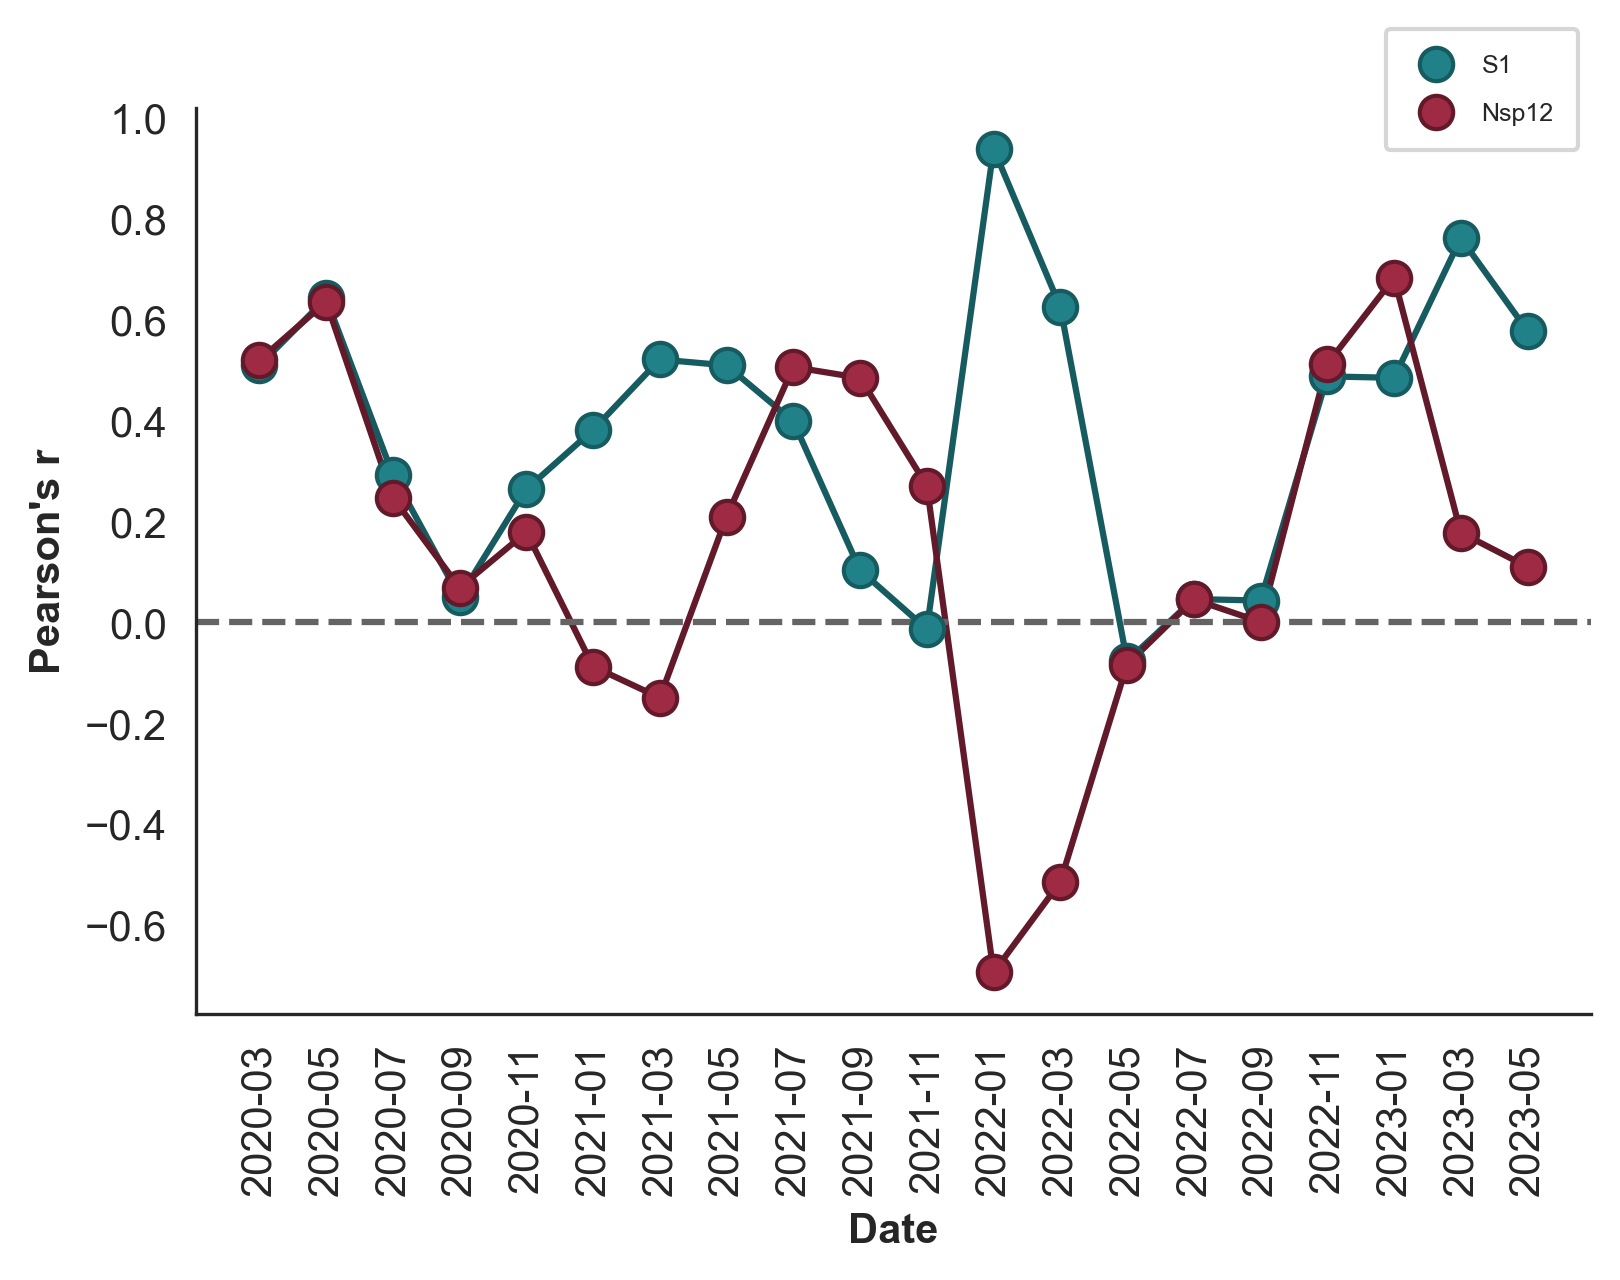

In [53]:
correlations_over_time(pearsons_df_sars2, genes_to_plot=['S1', 'Nsp12'])

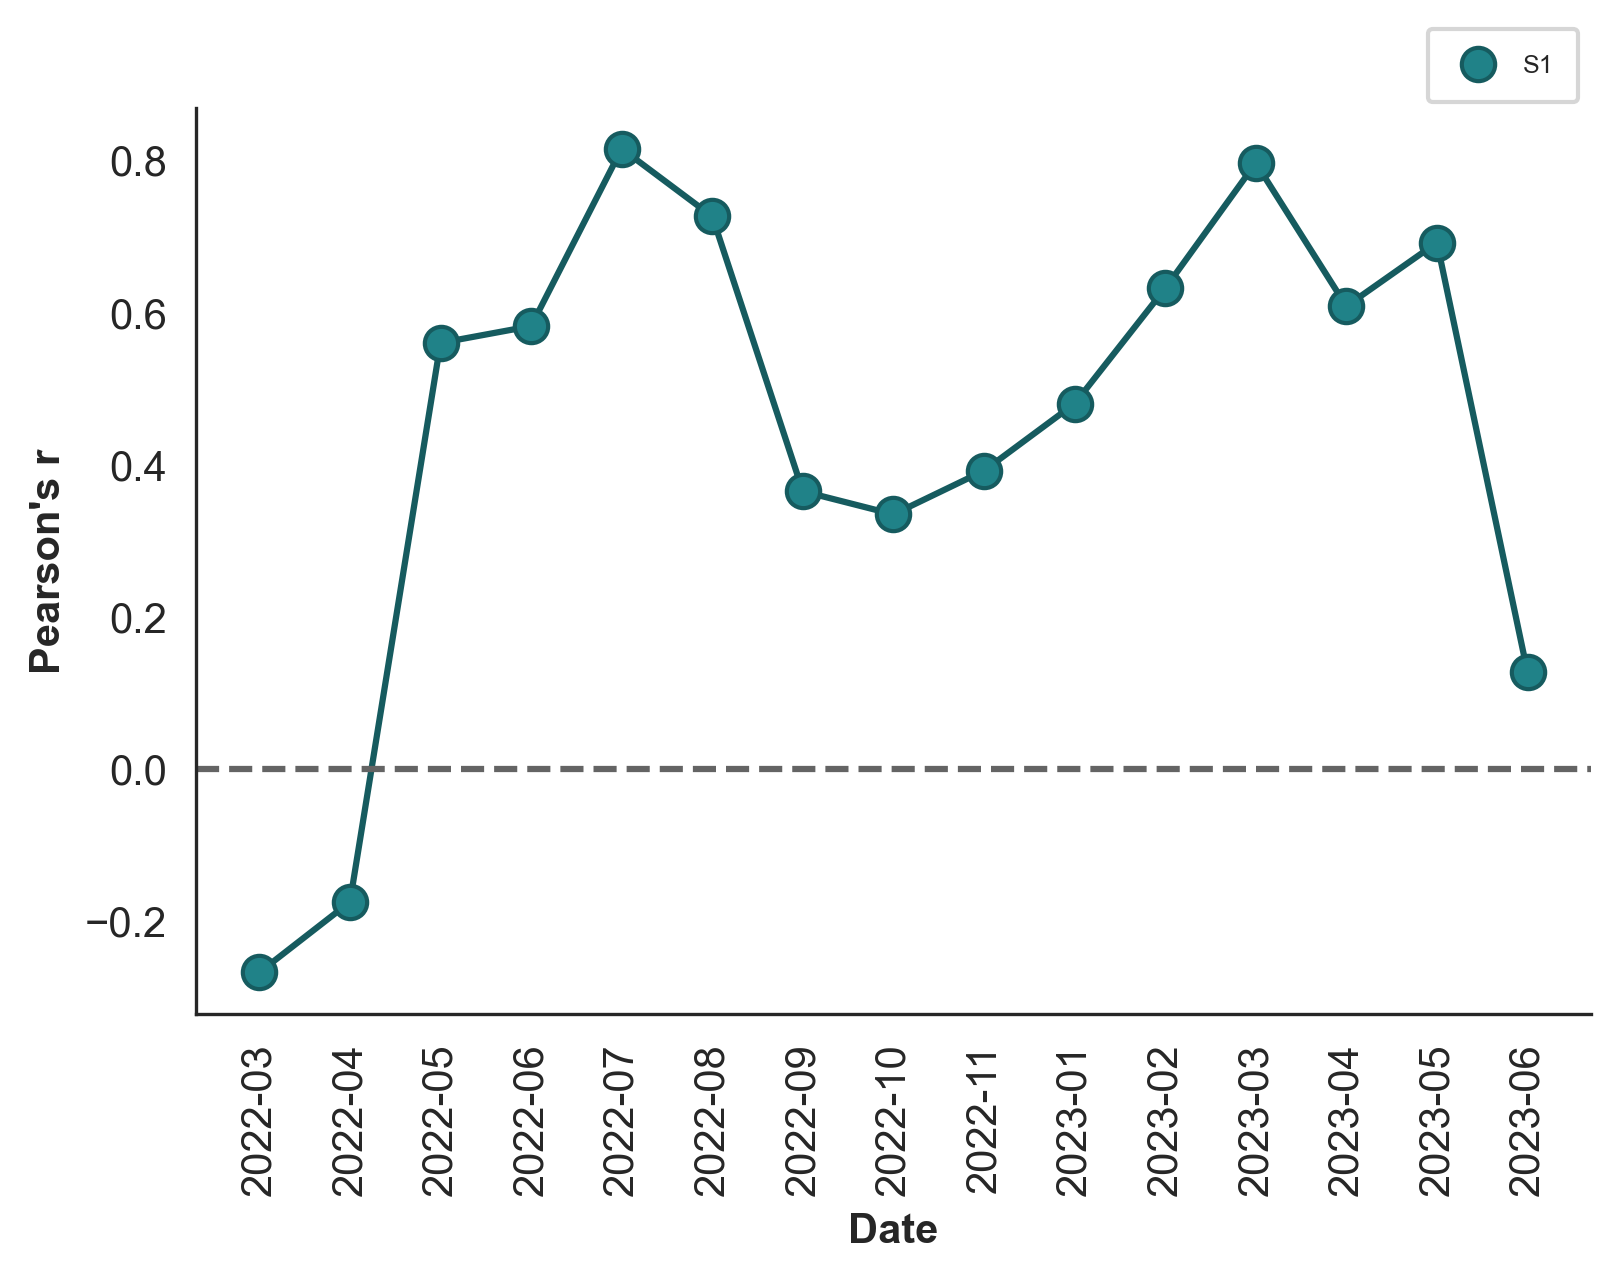

In [42]:
correlations_over_time(pearsons_df_21L, genes_to_plot=['S1'])

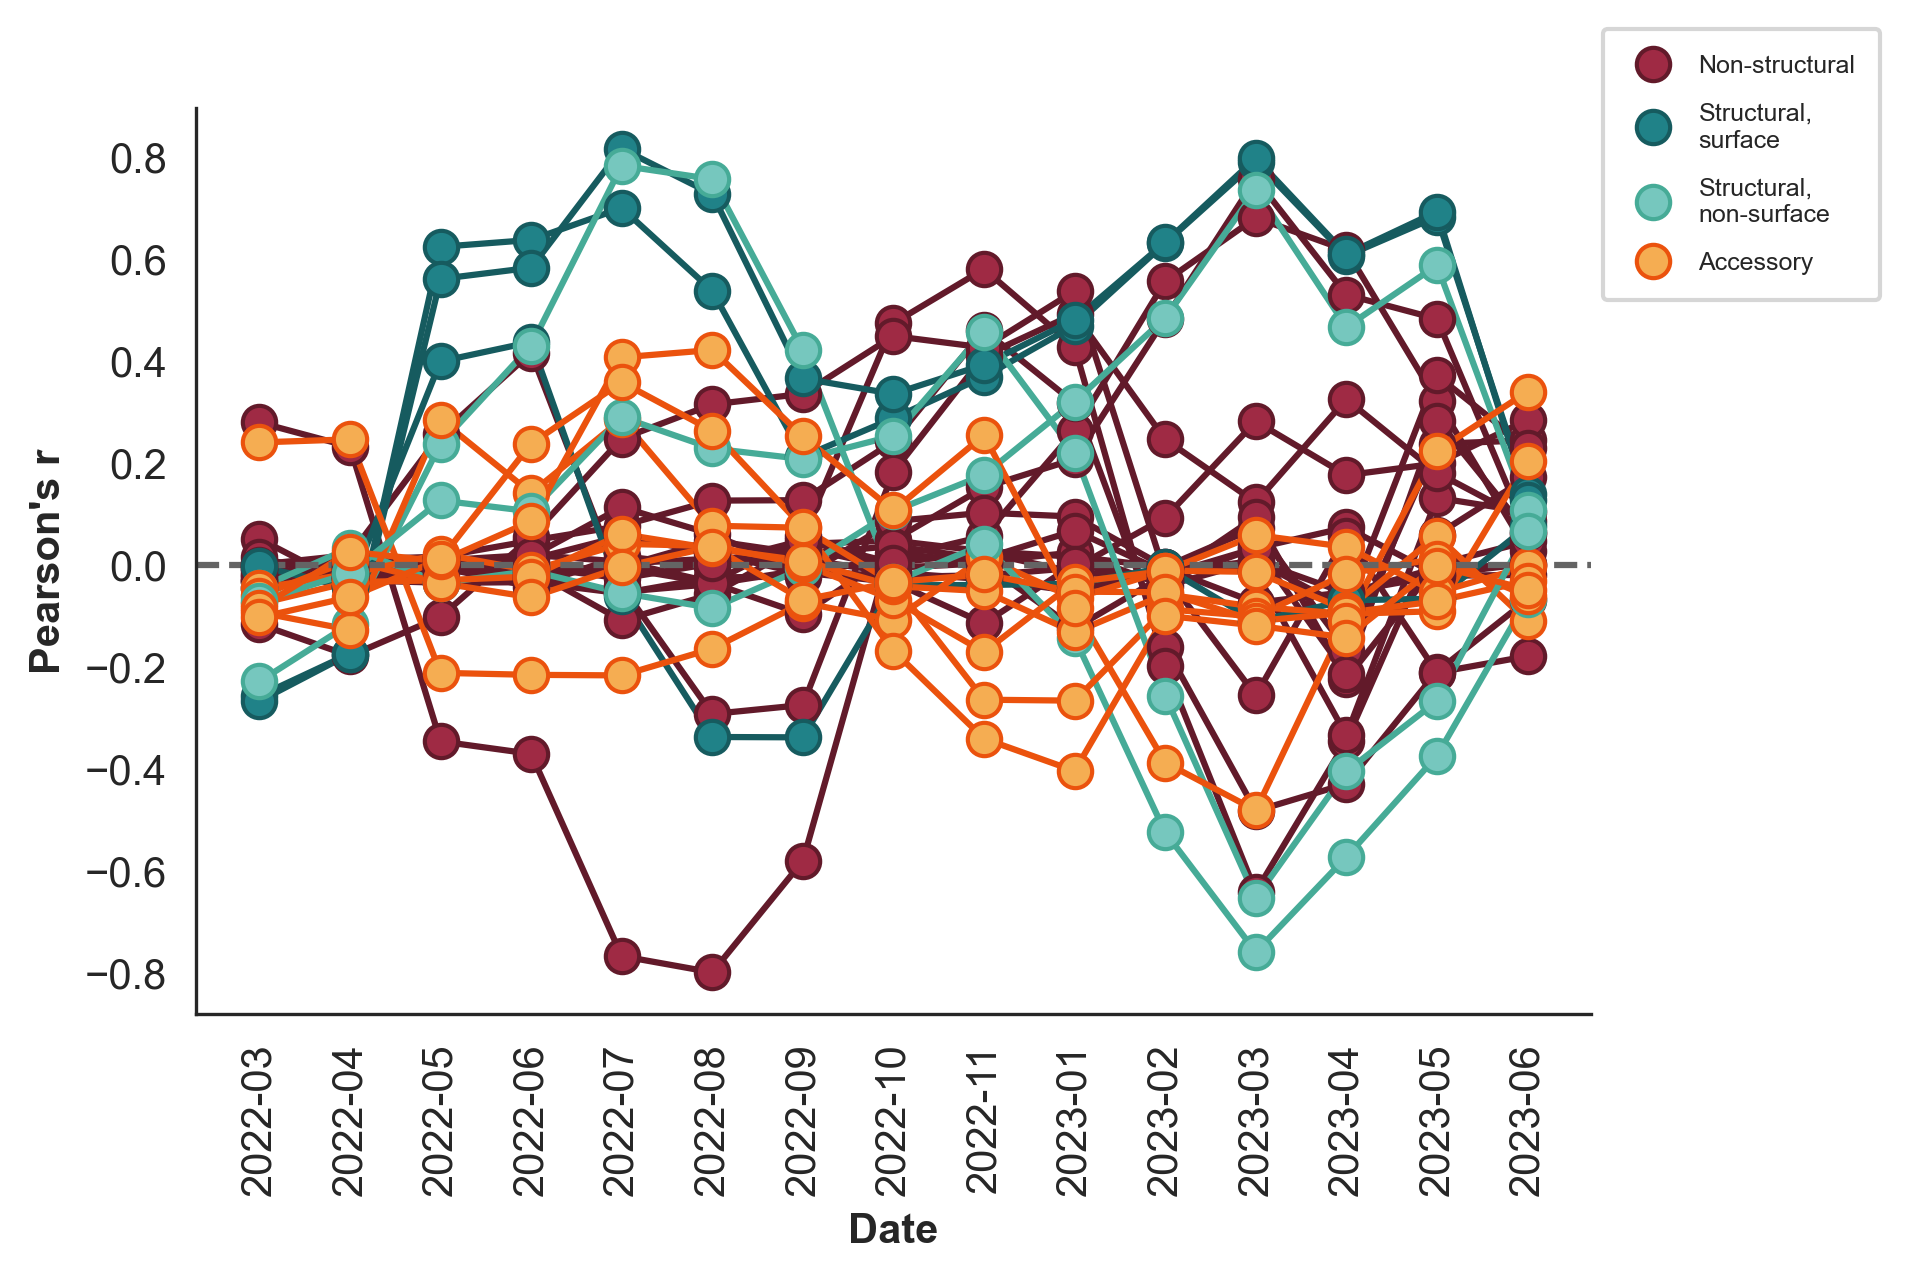

In [24]:
correlations_over_time(pearsons_df_21L)

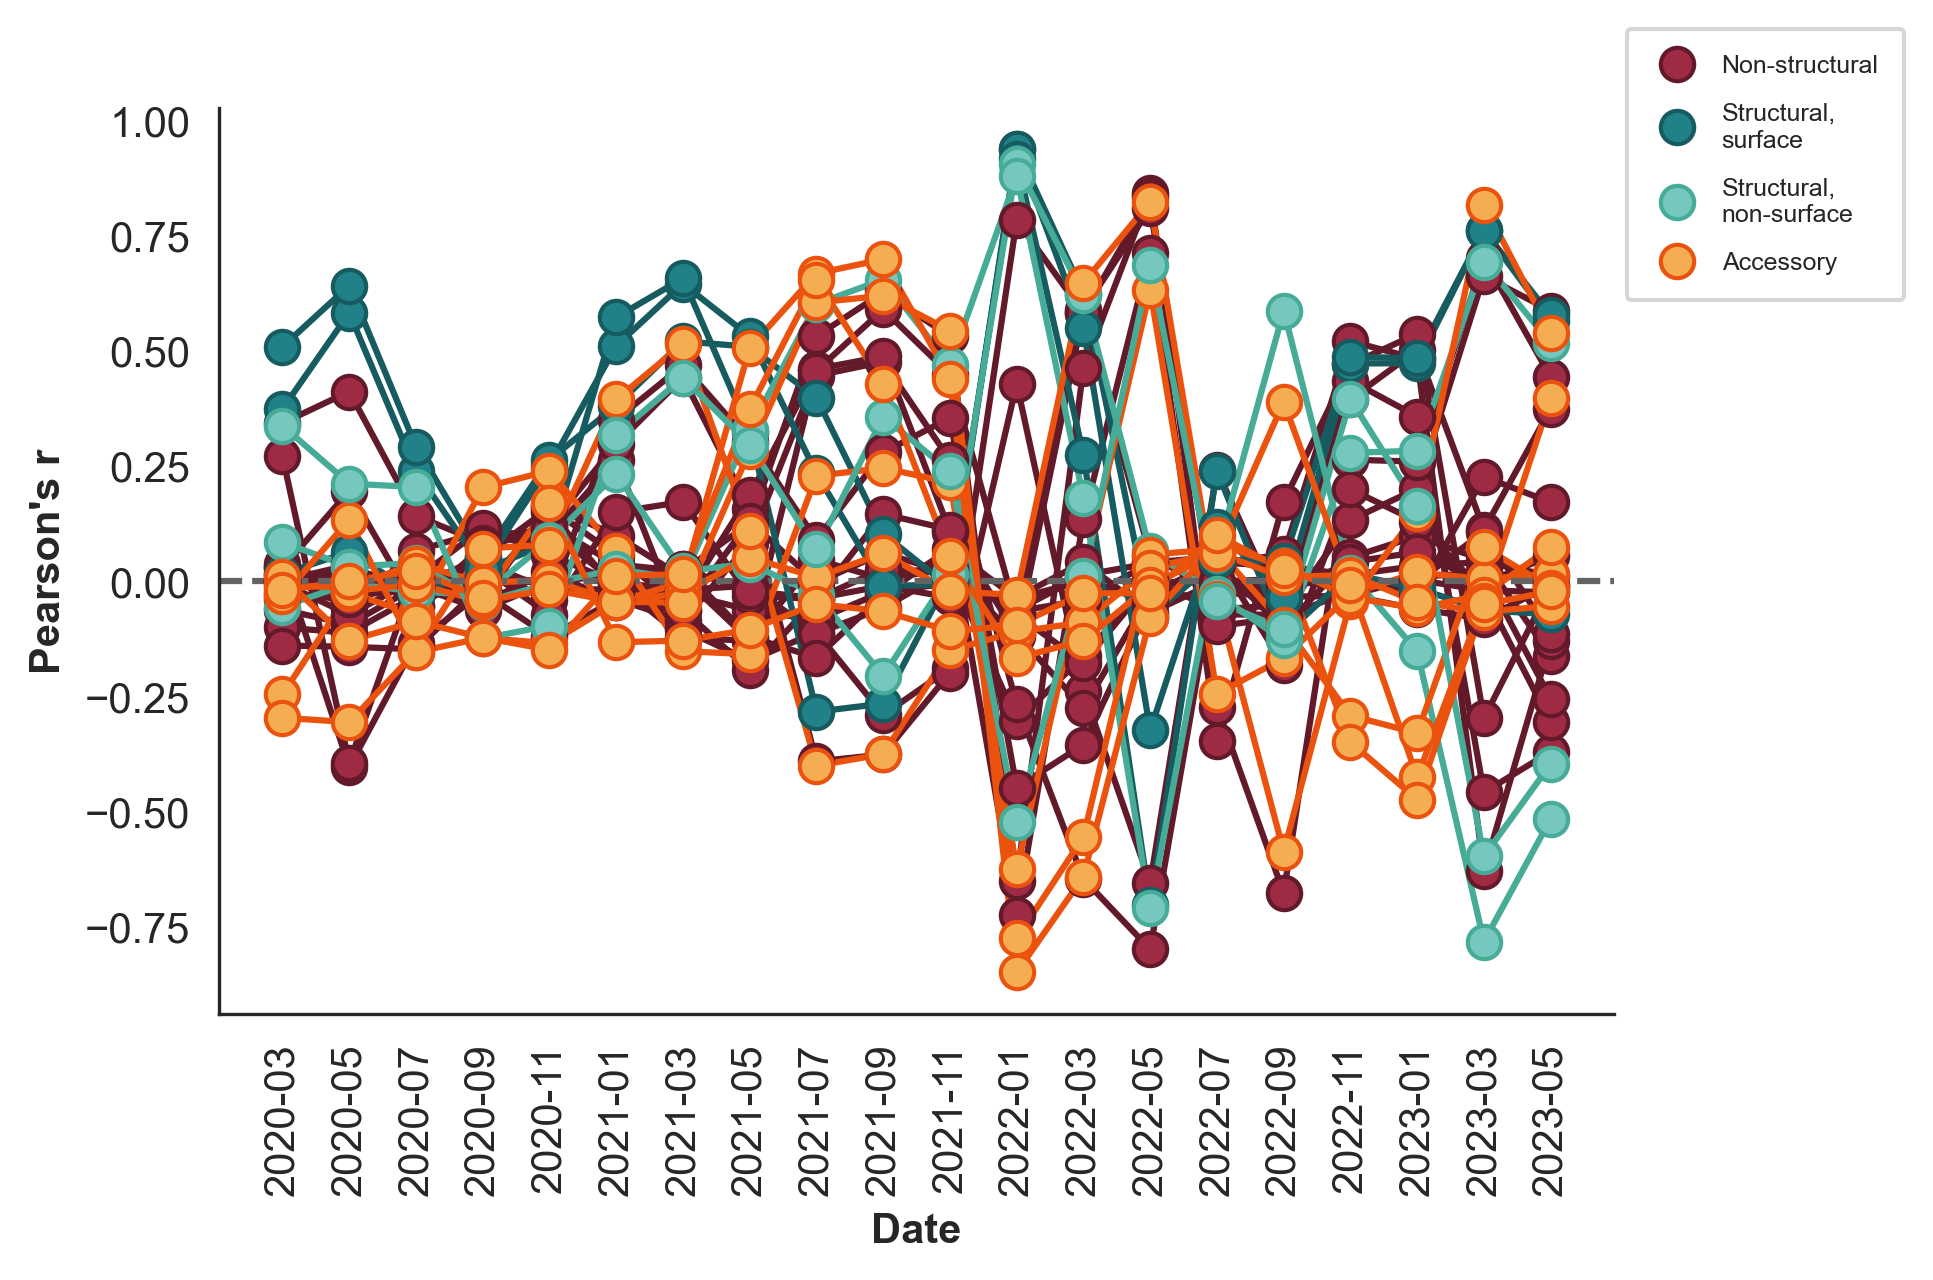

In [17]:
correlations_over_time(pearsons_df_sars2)